In [2]:
import argparse
import os
import re
import numpy as np

import statistics
import msprime
from IPython.display import SVG, display
import tsinfer
import scipy
import math
import numpy
import tskit
import io
import builtins
import sys
from tqdm.notebook import tqdm
from tskit import MISSING_DATA
import pickle
import random
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import matrix, spmatrix, sparse
from cvxopt.solvers import qp, options
from cvxopt import blas
from cvxopt import spdiag
import statsmodels
from statsmodels.nonparametric.kernel_regression import KernelReg
from scipy.signal import savgol_filter
import time
import bisect


def find_s(elem, sorted_list):
    'Locate the leftmost value exactly equal to x'
    i = bisect.bisect_left(sorted_list, elem)
    if i != len(sorted_list) and sorted_list[i] == elem:
        return i


def find_s_se(elem, sorted_list):
    'Locate the leftmost value smaller or equal to x'
    i = bisect.bisect_right(sorted_list, elem)
    if i != 0:
        return i-1
    else:
        print("error")


def find_s_s(elem, sorted_list):
    'Locate the leftmost value smaller or equal to x'
    i = bisect.bisect_left(sorted_list, elem)
    if i != 0:
        return i
    else:
        return 0

    
file = open("recombination_map_chr21.dat","rb")
rmap = pickle.load(file)
file.close

sam=tsinfer.load("tgp_chr21.samples")

MSLlist = []
for i in range(len(sam.individuals_population)):
    if sam.individuals_population[i]==13:
        MSLlist.append(i)
newdata = sam.subset(individuals=MSLlist)

        
seq_len = 48129897
sam_size = 85
r = rmap
mu = 1.375*10**(-8)
# gene_conver = 10**(-8)
# track_len = 100
# epsilon = 0.0001
totaliter=1

simtime = 100
# priormu = [1.0*10**(-8), 2.0*10**(-8)]
# prioreps = [0, 0.0002]
# accept_threshold = [1000,400]
freqconsider = [1,40]
priorinipop = [25000, 5000]
priorinirate = [-0.001 , 0.001]




inipopsimlist = []
iniratesimlist = []
summary_sta1_simlist = []
summary_sta2_simlist = []
summary_sta3_simlist = []
summary_sta4_simlist = []
current_pop = []

for iter in range(totaliter):

    sitefreq = numpy.sum(newdata.sites_genotypes,1)
    siteuse =  numpy.where( (sitefreq>freqconsider[0] ) * ( sitefreq<freqconsider[1] ) )[0]  
    print("siteuse_rea",len(siteuse))

    datause = newdata.subset(sites = siteuse)

    inferred_ts = tsinfer.infer(datause,path_compression=False)



    mts = inferred_ts

    ###############################################################################
    msites = mts.tables.mutations.site
    sitepos = mts.tables.sites.position
    mpos = []
    for i in range(len(msites)):
        cursite = msites[i]
        mpos.append(sitepos[cursite])
    mpos = numpy.array(mpos)
    mnodes = mts.tables.mutations.node
    ec = mts.tables.edges.child
    ep = mts.tables.edges.parent
    el = mts.tables.edges.left
    er = mts.tables.edges.right


    leftmost = min(el)
    rightmost = max(er)
    for i in range(len(el)):
        if el[i] == leftmost:
            el[i] = 0
        if er[i] == rightmost:
            er[i] = seq_len


    if len(mpos) == 0:
        mpos_sn = []
        mnodes_sn = []
    else:
        mnp_sn = numpy.transpose(sorted(numpy.transpose(numpy.array([mnodes,mpos])).tolist()))
        mnodes_sn = mnp_sn[0]
        mpos_sn = mnp_sn[1]

    eclrp_sc = numpy.transpose(sorted(numpy.transpose(numpy.array([ec,el,er,ep])).tolist()))
    ec_sc = eclrp_sc[0]
    el_sc = eclrp_sc[1]
    er_sc = eclrp_sc[2]
    ep_sc = eclrp_sc[3]
    enm_sc = [[] for i in range(len(ec_sc))]

    curedge = 0
    for i in range(len(mnodes_sn)):
        curnodemu = mnodes_sn[i] 
        cursitemu = mpos_sn[i]
        for j in range(curedge,len(ec_sc)):
            if curnodemu == ec_sc[j]:

                if er_sc[j] > cursitemu and el_sc[j] <= cursitemu:

                    enm_sc[j].append(cursitemu)  

                    curedge = j
                    break
                if el_sc[j] > cursitemu:
                    curedge = j
                    break

            if ec_sc[j] > mnodes_sn[i] or j == len(ec_sc)-1:
                #print("missing mutations")
                curedge = j
                break




    ###########################################################################
    ###########################################################################
    ##########################################################################

    clocate = []
    curc = -1
    for i in range(len(ec_sc)):
        while ec_sc[i] != curc:
            curc=curc+1
            clocate.append(i)
    clocate.append(len(ec_sc))




    abdlist = []

    for i in range(0,2*sam_size-1):
        for j in range(i+1,i+2):
            canabd = []
            curleft = 0
            curright =seq_len
            #start = 0
            while curleft != seq_len:
                curp1 = i
                curp2 = j 
                curmed = []
                while curp1 != curp2:
                    if curp1 < curp2:
                        begin1 = clocate[curp1]
                        end = clocate[curp1+1]
                        s_range = el_sc[begin1:end]
                        begin2 = find_s_se(curleft,s_range)
                        for k in range(begin1+begin2,end):
                            if el_sc[k]<=curleft and er_sc[k] > curleft:
                                curp1 = int(ep_sc[k])
                                curoldr = curright
                                curright = min(er_sc[k],curright)

                                curmed.append(k)

                                break

                    else:
                        begin1 = clocate[curp2]
                        end = clocate[curp2+1]
                        s_range = el_sc[begin1:end]
                        begin2 = find_s_se(curleft,s_range)
                        for k in range(begin1+begin2,end):
                            if el_sc[k]<=curleft and er_sc[k] > curleft:
                                curp2 = int(ep_sc[k])
                                curoldr = curright
                                curright = min(er_sc[k],curright) 

                                curmed.append(k)

                                break

                canmution = []
                for k in range(len(curmed)):
                    edgemu = enm_sc[curmed[k]]
                    startt = find_s_s(curleft,edgemu)
                    endd = find_s_s(curright,edgemu)                    
                    canmution = canmution + edgemu[startt:endd] 

                canabd.append([i,j,curleft,curright,curp1,canmution])
                curleft = curright
                curright = seq_len





            if len(canabd)==1:
                abdlist = abdlist + canabd
            else:
                curabd = [canabd[0][0],canabd[0][1],canabd[0][2],canabd[0][3],canabd[0][4],canabd[0][5]]
                for k in range(1,len(canabd)):
                    if canabd[k][4] != canabd[k-1][4]:
                        abdlist.append(curabd)
                        curabd = [canabd[k][0],canabd[k][1],canabd[k][2],canabd[k][3],canabd[k][4],canabd[k][5]]
                    else:
                        curabd[3] = canabd[k][3]
                        curabd[5] = curabd[5] + canabd[k][5]
                    if k == len(canabd)-1:
                        abdlist.append(curabd)



#             print("abdlist sample:",i)
    print("numibd",len(abdlist))
    
    abduse = abdlist

#########################################################################

    tolnummu = 0
    for i in range(len(abduse)):
        tolnummu = tolnummu+len(abduse[i][5])


    muloclist = np.zeros(tolnummu)
    indd = 0
    for i in range(len(abduse)):
        abdc = abduse[i]
        lee = len(abdc[5])
        muloclist[indd:(indd+lee)] = abdc[5]
        indd = indd+lee

    smulist = numpy.sort(muloclist)
    count2 = 0
    curloc = -1
    curcount = 1
    for i in range(len(smulist)):
        if smulist[i] == curloc:
            curcount = curcount+1
        else:
            if curcount ==2:
                count2 = count2+1
            curcount = 1
            curloc = smulist[i]

#         summary_sta1_sim = (len(smulist) - 2*count2)/len(abduse)        
#         summary_sta2_sim = (2*count2) / len(abduse)

    summary_sta1_inf = (len(smulist) - 2*count2)        
    summary_sta2_inf = (2*count2)  




########################################################################            



    lenlist = numpy.zeros(len(abduse))
    for i in range(len(abduse)):
        lenlist[i] = abduse[i][3] - abduse[i][2]

    summary_sta3_inf = statistics.mean(lenlist) 
    summary_sta4_inf = statistics.stdev(lenlist) 

#################################################################################################
    stime = time.time()

    for run in range(simtime):
        
        popsim = numpy.random.uniform(priorinipop[0],priorinipop[1])
        ratesim = numpy.random.uniform(priorinirate[0],priorinirate[1])

#         if run == 0:
#             popsim = 16000
#             ratesim = 0.000
#         if run == 1:
#             popsim = 16000
#             ratesim = 0.0016
#         if run == 2:
#             popsim = 40000
#             ratesim = 0.003
#         if run == 3:
#             popsim = 40000
#             ratesim = 0.003            
#         if run == 4:
#             popsim = 5000
#             ratesim = -0.0001         
#         if run == 5:
#             popsim = 2000
#             ratesim = 0.000   
        
        
        
        inipopsimlist.append(popsim)
        iniratesimlist.append(ratesim)
        
        
#         demo_model = msprime.Demography.isolated_model([popsim], growth_rate=[ratesim])
#         demo_model.add_population_parameters_change(800,  initial_size=None, growth_rate=0, population=None)


        genpoint = [0*5/5.2,400*5/5.2,800*5/5.2,1200*5/5.2,1600*5/5.2,2000*5/5.2,2400*5/5.2,2800*5/5.2,\
                    3200*5/5.2,3600*5/5.2,4000*5/5.2,8000*5/5.2,12000*5/5.2,16000*5/5.2,20000*5/5.2]
        inipopsize =[12500,12500,11900,11500,10600,9600,9000,9600,10600,11900,13500,28500,26900,20800,17300]
        genuse = []
        inipuse = []
        gruse = []
        for i in range(len(genpoint)-1):
            addplist = []
            for j in range(10):
                addplist.append(genpoint[i] + (genpoint[i+1]-genpoint[i])/10*j)
            genuse = genuse + addplist               
        for i in range(len(inipopsize)-1):
            addplist = []
            for j in range(10):
                addplist.append(inipopsize[i] + (inipopsize[i+1]-inipopsize[i])/10*j)
            inipuse = inipuse + addplist
        genuse.append(genpoint[len(genpoint)-1])
        inipuse.append(inipopsize[len(inipopsize)-1])

        
        ind1000 = 0
        for i in range(len(genuse)):
            if genuse[i]<1000:
                ind1000 = i
        consta = inipuse[ind1000] - popsim*numpy.exp(-ratesim*1000)        
        for i in range(len(genuse)):
            if genuse[i]<1000:
                inipuse[i] = consta + popsim*numpy.exp(-ratesim*genuse[i]) 
        for i in range(len(genuse)-1):
            gruse.append( numpy.log( inipuse[i]/inipuse[i+1] )/(genuse[i+1] - genuse[i])  )
        gruse.append(0)
        
        current_pop.append( consta + popsim)
        if consta+popsim <1000:
            demo_model = msprime.Demography.isolated_model([1000], growth_rate=[0.001])
        else:
            demo_model = msprime.Demography.isolated_model([inipuse[0]], growth_rate=[gruse[0]])
            for i in range(1,len(genuse)):
                demo_model.add_population_parameters_change(genuse[i],  initial_size=inipuse[i], growth_rate=gruse[i], population=None)

                
                

#         for i in range(len(genuse)-1):
#             gruse.append( numpy.log( inipuse[i]/inipuse[i+1] )/(genuse[i+1] - genuse[i])  )
#         gruse.append(0)
        

#         demo_model = msprime.Demography.isolated_model([inipuse[0]], growth_rate=[gruse[0]])
#         for i in range(1,len(genuse)):
#             demo_model.add_population_parameters_change(genuse[i],  initial_size=inipuse[i], growth_rate=gruse[i], population=None)





        ts = msprime.sim_ancestry(
            samples=sam_size,
            recombination_rate= r, 
            sequence_length= seq_len,
            record_provenance=False,
#             population_size = pop_size,
#             gene_conversion_rate = gene_conver ,
#             gene_conversion_tract_length = track_len,
            #random_seed =seed,
            #discrete_genome=False
            demography = demo_model
            )
        # Visualise the simulated ancestral history.
        #SVG(ts.draw_svg())

        #ts.num_trees
        
        print("done gene")

        mts = msprime.sim_mutations(ts, rate = mu,
                                    #discrete_genome=False,
                                    #random_seed=seed
                                  )

        print("done mu")

        sample_data = tsinfer.SampleData.from_tree_sequence(mts, use_sites_time=None, use_individuals_time=None)

    
        sitefreq = numpy.sum(sample_data.sites_genotypes,1)
        siteuse =  numpy.where( (sitefreq>freqconsider[0] ) * ( sitefreq<freqconsider[1] ) )[0]  
        print("siteuse_sim",len(siteuse))

        datause = sample_data.subset(sites = siteuse)

        inferred_ts = tsinfer.infer(datause,path_compression=False)



        mts = inferred_ts

        ###############################################################################
        msites = mts.tables.mutations.site
        sitepos = mts.tables.sites.position
        mpos = []
        for i in range(len(msites)):
            cursite = msites[i]
            mpos.append(sitepos[cursite])
        mpos = numpy.array(mpos)
        mnodes = mts.tables.mutations.node
        ec = mts.tables.edges.child
        ep = mts.tables.edges.parent
        el = mts.tables.edges.left
        er = mts.tables.edges.right


        leftmost = min(el)
        rightmost = max(er)
        for i in range(len(el)):
            if el[i] == leftmost:
                el[i] = 0
            if er[i] == rightmost:
                er[i] = seq_len


        if len(mpos) == 0:
            mpos_sn = []
            mnodes_sn = []
        else:
            mnp_sn = numpy.transpose(sorted(numpy.transpose(numpy.array([mnodes,mpos])).tolist()))
            mnodes_sn = mnp_sn[0]
            mpos_sn = mnp_sn[1]

        eclrp_sc = numpy.transpose(sorted(numpy.transpose(numpy.array([ec,el,er,ep])).tolist()))
        ec_sc = eclrp_sc[0]
        el_sc = eclrp_sc[1]
        er_sc = eclrp_sc[2]
        ep_sc = eclrp_sc[3]
        enm_sc = [[] for i in range(len(ec_sc))]

        curedge = 0
        for i in range(len(mnodes_sn)):
            curnodemu = mnodes_sn[i] 
            cursitemu = mpos_sn[i]
            for j in range(curedge,len(ec_sc)):
                if curnodemu == ec_sc[j]:

                    if er_sc[j] > cursitemu and el_sc[j] <= cursitemu:

                        enm_sc[j].append(cursitemu)  

                        curedge = j
                        break
                    if el_sc[j] > cursitemu:
                        curedge = j
                        break

                if ec_sc[j] > mnodes_sn[i] or j == len(ec_sc)-1:
                    #print("missing mutations")
                    curedge = j
                    break




        ###########################################################################
        ###########################################################################
        ##########################################################################

        clocate = []
        curc = -1
        for i in range(len(ec_sc)):
            while ec_sc[i] != curc:
                curc=curc+1
                clocate.append(i)
        clocate.append(len(ec_sc))




        abdlist = []

        for i in range(0,2*sam_size-1):
            for j in range(i+1,i+2):
                canabd = []
                curleft = 0
                curright =seq_len
                #start = 0
                while curleft != seq_len:
                    curp1 = i
                    curp2 = j 
                    curmed = []
                    while curp1 != curp2:
                        if curp1 < curp2:
                            begin1 = clocate[curp1]
                            end = clocate[curp1+1]
                            s_range = el_sc[begin1:end]
                            begin2 = find_s_se(curleft,s_range)
                            for k in range(begin1+begin2,end):
                                if el_sc[k]<=curleft and er_sc[k] > curleft:
                                    curp1 = int(ep_sc[k])
                                    curoldr = curright
                                    curright = min(er_sc[k],curright)

                                    curmed.append(k)

                                    break

                        else:
                            begin1 = clocate[curp2]
                            end = clocate[curp2+1]
                            s_range = el_sc[begin1:end]
                            begin2 = find_s_se(curleft,s_range)
                            for k in range(begin1+begin2,end):
                                if el_sc[k]<=curleft and er_sc[k] > curleft:
                                    curp2 = int(ep_sc[k])
                                    curoldr = curright
                                    curright = min(er_sc[k],curright) 

                                    curmed.append(k)

                                    break

                    canmution = []
                    for k in range(len(curmed)):
                        edgemu = enm_sc[curmed[k]]
                        startt = find_s_s(curleft,edgemu)
                        endd = find_s_s(curright,edgemu)                    
                        canmution = canmution + edgemu[startt:endd] 

                    canabd.append([i,j,curleft,curright,curp1,canmution])
                    curleft = curright
                    curright = seq_len





                if len(canabd)==1:
                    abdlist = abdlist + canabd
                else:
                    curabd = [canabd[0][0],canabd[0][1],canabd[0][2],canabd[0][3],canabd[0][4],canabd[0][5]]
                    for k in range(1,len(canabd)):
                        if canabd[k][4] != canabd[k-1][4]:
                            abdlist.append(curabd)
                            curabd = [canabd[k][0],canabd[k][1],canabd[k][2],canabd[k][3],canabd[k][4],canabd[k][5]]
                        else:
                            curabd[3] = canabd[k][3]
                            curabd[5] = curabd[5] + canabd[k][5]
                        if k == len(canabd)-1:
                            abdlist.append(curabd)


    #             print("abdlist sample:",i)
        print("numibd",len(abdlist))

        abduse = abdlist


        tolnummu = 0
        for i in range(len(abduse)):
            tolnummu = tolnummu+len(abduse[i][5])


        muloclist = np.zeros(tolnummu)
        indd = 0
        for i in range(len(abduse)):
            abdc = abduse[i]
            lee = len(abdc[5])
            muloclist[indd:(indd+lee)] = abdc[5]
            indd = indd+lee
            
        smulist = numpy.sort(muloclist)
        count2 = 0
        curloc = -1
        curcount = 1
        for i in range(len(smulist)):
            if smulist[i] == curloc:
                curcount = curcount+1
            else:
                if curcount ==2:
                    count2 = count2+1
                curcount = 1
                curloc = smulist[i]
        
#         summary_sta1_sim = (len(smulist) - 2*count2)/len(abduse)        
#         summary_sta2_sim = (2*count2) / len(abduse)

        summary_sta1_sim = (len(smulist) - 2*count2)        
        summary_sta2_sim = (2*count2)  

        summary_sta1_simlist.append(summary_sta1_sim)
        summary_sta2_simlist.append(summary_sta2_sim)
        
        
########################################################################            
        
        

        lenlist = numpy.zeros(len(abduse))
        for i in range(len(abduse)):
            lenlist[i] = abduse[i][3] - abduse[i][2]

        summary_sta3_simlist.append( statistics.mean(lenlist) )
        summary_sta4_simlist.append( statistics.stdev(lenlist) )
        
        print("-----------------------------------")
        print("current_pop",current_pop )
#         print(inipopsimlist )
#         print(iniratesimlist )
        print(summary_sta1_simlist,summary_sta1_inf)
        print(summary_sta2_simlist,summary_sta2_inf)
        print(summary_sta3_simlist,summary_sta3_inf)
        print(summary_sta4_simlist,summary_sta4_inf)
        print(time.time()-stime, run)
        print("-----------------------------------")




byrun = 1
name0 = "z_ne_realcurrentpop_"+"run="+str(byrun) +"MSL_chr21_efibd.dat"
name1 = "z_ne_realpopsimall_"+"run="+str(byrun) +"MSL_chr21_efibd.dat"
name2 = "z_ne_realratesimall_"+"run="+str(byrun) +"MSL_chr21_efibd.dat"
name3 = "z_ne_realsta1simall_"+"run="+str(byrun) +"MSL_chr21_efibd.dat"
name4 = "z_ne_realsta2simall_"+"run="+str(byrun) +"MSL_chr21_efibd.dat"
name5 = "z_ne_realsta1inf_"+"run="+str(byrun) +"MSL_chr21_efibd.dat"
name6 = "z_ne_realsta2inf_"+"run="+str(byrun) +"MSL_chr21_efibd.dat"
name7 = "z_ne_realsta3simall_"+"run="+str(byrun) +"MSL_chr21_efibd.dat"
name8 = "z_ne_realsta4simall_"+"run="+str(byrun) +"MSL_chr21_efibd.dat"
name9 = "z_ne_realsta3inf_"+"run="+str(byrun) +"MSL_chr21_efibd.dat"
name10 = "z_ne_realsta4inf_"+"run="+str(byrun) +"MSL_chr21_efibd.dat"

file = open(name0,"wb") 
pickle.dump(current_pop,file)
file.close()

file = open(name1,"wb") 
pickle.dump(inipopsimlist,file)
file.close()

file = open(name2,"wb") 
pickle.dump(iniratesimlist,file)
file.close()

file = open(name3,"wb") 
pickle.dump(summary_sta1_simlist,file)
file.close()

file = open(name4,"wb") 
pickle.dump(summary_sta2_simlist,file)
file.close()

file = open(name5,"wb") 
pickle.dump(summary_sta1_inf,file)
file.close()

file = open(name6,"wb") 
pickle.dump(summary_sta2_inf,file)
file.close()

file = open(name7,"wb") 
pickle.dump(summary_sta3_simlist,file)
file.close()

file = open(name8,"wb") 
pickle.dump(summary_sta4_simlist,file)
file.close()

file = open(name9,"wb") 
pickle.dump(summary_sta3_inf,file)
file.close()

file = open(name10,"wb") 
pickle.dump(summary_sta4_inf,file)
file.close()




siteuse_rea 231187
numibd 235336
done gene
done mu
siteuse_sim 183106
numibd 173949
-----------------------------------
current_pop [11700.0]
[4187482] 4293485
[390] 1010
[61232.391206618035] 45260.02489206921
[176854.82438694075] 148388.00113485186
362.54689478874207 0
-----------------------------------
done gene
done mu
siteuse_sim 188977
numibd 170888
-----------------------------------
current_pop [11700.0, 24469.655712085514]
[4187482, 4197426] 4293485
[390, 824] 1010
[61232.391206618035, 62329.20519872665] 45260.02489206921
[176854.82438694075, 174345.19026593215] 148388.00113485186
740.0461182594299 1
-----------------------------------
done gene
done mu
siteuse_sim 191847
numibd 177860
-----------------------------------
current_pop [11700.0, 24469.655712085514, 49708.51726528544]
[4187482, 4197426, 4144959] 4293485
[390, 824, 714] 1010
[61232.391206618035, 62329.20519872665, 59885.93960418306] 45260.02489206921
[176854.82438694075, 174345.19026593215, 167703.78482808918] 1483

In [8]:
numpy.exp(0.001*1000)*20000

54365.636569180904

In [273]:
numpy.log(17400/2800)/1600

0.0011417817431495782

In [10]:
print(summary_sta1_simlist,summary_sta1_inf)

[131917.87691659856, 137940.00308222283] 83605.94053328519


In [11]:
print(summary_sta2_simlist,summary_sta2_inf)

[319061.2179425511, 326424.3238242735] 240396.64324638573


In [124]:
inipopsimlist

[76000, 76000, 30000, 30000, 120000, 120000]

In [125]:
iniratesimlist

[0.0033, 0.0033, 0.004, 0.004, 0.002, 0.002]

In [129]:
120000*numpy.exp(-1200*0.002) 

10886.154394729501

In [130]:
summary_sta1_simlist

[2344345.562264151,
 2378972.1105032824,
 2438101.860213044,
 2414636.8784008883,
 1396668.7778610426,
 1251081.9959723821]

In [131]:
summary_sta2_simlist

[4372968.630850762,
 4517109.553498169,
 4640203.3000262,
 4673087.035534496,
 2726643.539254386,
 2469605.7512018387]

In [58]:
print(newdata)

path                  = None
file_size             = -1 Byte
format_name           = tsinfer-sample-data
format_version        = (5, 0)
finalised             = True
uuid                  = b9ca7636-ecf7-46e1-8ee7-49341e38a07c
num_provenances       = 2
provenances/timestamp = shape=(2,); dtype=object;
provenances/record    = shape=(2,); dtype=object;
sequence_length       = 63025522.0
metadata_schema       = {'additionalProperties': True, 'codec': 'json', 'properties': {}, 'required': [], 'type': 'object'}
metadata              = {}
num_populations       = 26
num_individuals       = 104
num_samples           = 208
num_sites             = 1552394
populations/metadata_schema = None
populations/metadata  = shape=(26,); dtype=object;
individuals/metadata_schema = None
individuals/metadata  = shape=(104,); dtype=object;
individuals/location  = shape=(104,); dtype=object;
individuals/time      = shape=(104,); dtype=float64;uncompressed size=832 Bytes
individuals/population = shape=(104,); dty

In [59]:
max(numpy.sum(newdata.sites_genotypes,1) )

208

In [85]:
aa = numpy.sum(newdata.sites_genotypes,1)<2
sitepos = newdata.sites_position
sitegen = newdata.sites_genotypes

In [86]:
sum(aa)

1375936

In [87]:
len(aa)

1552394

In [88]:
1552000-1376000

176000

In [65]:
sum(aa)/len(aa)

0.90507049112532

In [47]:
newdata.sites_time[0:3]

array([nan, nan, nan])

array([ True,  True,  True, ...,  True, False,  True])

In [16]:
17%10

7

In [3]:
aa = numpy.array( [ [1,2,3],[4,5,6]  ])
aa

array([[1, 2, 3],
       [4, 5, 6]])

In [4]:
numpy.sum(aa,1)

array([ 6, 15])

In [219]:
mtsjjj

In [228]:
sample_datajjj = tsinfer.SampleData.from_tree_sequence(mtsjjj, use_sites_time=True, use_individuals_time=None)

In [266]:
sum(sample_datajjj.sites_time[0:len(sample_datajjj.sites_time)]<1200)

116583

In [267]:
sum(sample_datajjj.sites_time[0:len(sample_datajjj.sites_time)]<2400)

151927

In [239]:
len(sample_datajjj.sites_time)

217095

In [ ]:
genty = sample_datajjj.sites_genotypes
sitetime = sample_datajjj.sites_time

sitefreq = numpy.sum(genty,1)


In [276]:
sum( (sitefreq < 100)*(sitetime[:]<2400) )/ sum((sitefreq < 100))

0.8350550134240602

In [255]:
sum( (sitefreq < 6)*(sitetime[:]<1200) )/ sum((sitefreq < 6))

0.9932123891976775

In [175]:
 sum((sitefreq < 6)*(sitefreq >1))

30663

In [145]:
sitefreq1 = numpy.sum(newdata.sites_genotypes,1)

In [172]:
 sum((sitefreq1 < 6)*(sitefreq1 >1))

33408

In [240]:
len(sample_data.sites_time)

209618

In [81]:
sum( (sitefreq < 2) )/len(sitefreq)

0.30985387785687524

In [89]:
len(sitefreq)

202844

In [90]:
202844*0.7

141990.8

In [55]:
aa = [True, False, True, True, False]

In [56]:
numpy.where(aa)[0]

array([0, 2, 3])

In [232]:
sample_data = tsinfer.SampleData.from_tree_sequence(mts, use_sites_time=True, use_individuals_time=None)

In [233]:
len(sample_data.sites_time)

110997

In [202]:
sitefreq2 = numpy.sum(sample_data.sites_genotypes,1)

In [209]:
sum((sitefreq2 < 4)*(sitefreq2 >1))

23786

In [211]:
sitetime2 = sample_data.sites_time

sum( (sitefreq2 < 200)*(sitefreq2 >1)*(sitetime2[:]<1200) )/ sum((sitefreq2 < 200)*(sitefreq2 >1))

0.9987745098039216

In [216]:
sum(sitetime2[:]<1200)

110026

In [224]:
len(sitetime2)

110161

In [191]:
sitefreq1 = numpy.sum(newdata.sites_genotypes,1)

In [196]:
sum((sitefreq1 < 4)*(sitefreq1 >1))

23701

In [174]:
numpy.log(17400/1400)/800

0.0031499974619990877

In [185]:
mu

1.3300000000000002e-08

In [188]:
seq_len

63025522

In [1]:
import argparse
import os
import re
import numpy as np

import statistics
import msprime
from IPython.display import SVG, display
import tsinfer
import scipy
import math
import numpy
import tskit
import io
import builtins
import sys
from tqdm.notebook import tqdm
from tskit import MISSING_DATA
import pickle
import random
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import matrix, spmatrix, sparse
from cvxopt.solvers import qp, options
from cvxopt import blas
from cvxopt import spdiag
import statsmodels
from statsmodels.nonparametric.kernel_regression import KernelReg
from scipy.signal import savgol_filter
import time
import bisect


def find_s(elem, sorted_list):
    'Locate the leftmost value exactly equal to x'
    i = bisect.bisect_left(sorted_list, elem)
    if i != len(sorted_list) and sorted_list[i] == elem:
        return i


def find_s_se(elem, sorted_list):
    'Locate the leftmost value smaller or equal to x'
    i = bisect.bisect_right(sorted_list, elem)
    if i != 0:
        return i-1
    else:
        print("error")


def find_s_s(elem, sorted_list):
    'Locate the leftmost value smaller or equal to x'
    i = bisect.bisect_left(sorted_list, elem)
    if i != 0:
        return i
    else:
        return 0

 
    
file = open("recombination_map.dat","rb")
rmap = pickle.load(file)
file.close

sam=tsinfer.load("tgp_chr20.samples")

MSLlist = []
for i in range(len(sam.individuals_population)):
    if sam.individuals_population[i]==13:
        MSLlist.append(i)
newdata = sam.subset(individuals=MSLlist)
        
    
    
seq_len = 63025522
sam_size = 85
r = rmap
mu = 1.375*10**(-8)
# gene_conver = 10**(-8)
# track_len = 100
# epsilon = 0.0001
totaliter=1

In [14]:
genpoint = [0*5/5.2,400*5/5.2,800*5/5.2,1200*5/5.2,1600*5/5.2,2000*5/5.2,2400*5/5.2,2800*5/5.2,\
            3200*5/5.2,3600*5/5.2,4000*5/5.2,8000*5/5.2,12000*5/5.2,16000*5/5.2,20000*5/5.2]
inipopsize =[12500,12500,11900,11500,10600,9600,9000,9600,10600,11900,13500,28500,26900,20800,17300]
genuse = []
inipuse = []
gruse = []
for i in range(len(genpoint)-1):
    addplist = []
    for j in range(10):
        addplist.append(genpoint[i] + (genpoint[i+1]-genpoint[i])/10*j)
    genuse = genuse + addplist
for i in range(len(inipopsize)-1):
    addplist = []
    for j in range(10):
        addplist.append(inipopsize[i] + (inipopsize[i+1]-inipopsize[i])/10*j)
    inipuse = inipuse + addplist
genuse.append(genpoint[len(genpoint)-1])
inipuse.append(inipopsize[len(inipopsize)-1])
for i in range(len(genuse)-1):
    gruse.append( numpy.log( inipuse[i]/inipuse[i+1] )/(genuse[i+1] - genuse[i])  )
gruse.append(0)
    

demo_model = msprime.Demography.isolated_model([inipuse[0]], growth_rate=[gruse[0]])
for i in range(1,len(genuse)):
    demo_model.add_population_parameters_change(genuse[i],  initial_size=inipuse[i], growth_rate=gruse[i], population=None)



ts = msprime.sim_ancestry(
        samples=sam_size,
        recombination_rate= r, 
        sequence_length= seq_len,
#         population_size = pop_size,
#         gene_conversion_rate = gene_conver ,
#         gene_conversion_tract_length = track_len,
        #random_seed =seed,
        #discrete_genome=False
        demography = demo_model
        )
    # Visualise the simulated ancestral history.
    #SVG(ts.draw_svg())

    #ts.num_trees

mtsjjj = msprime.sim_mutations(ts, rate = mu,
                            #discrete_genome=False,
                            #random_seed=seed
                          )

The provenance information for the resulting tree sequence is 2.77MB. This is nothing to worry about as provenance is a good thing to have, but if you want to save this memory/storage space you can disable provenance recording by setting record_provenance=False


In [17]:
sample_datajjj = tsinfer.SampleData.from_tree_sequence(mtsjjj, use_sites_time=True, use_individuals_time=None)

In [18]:
sum(sample_datajjj.sites_time[0:len(sample_datajjj.sites_time)]<1000)


107376

In [19]:
sum(sample_datajjj.sites_time[0:len(sample_datajjj.sites_time)]<2400)

149782

In [20]:
len(sample_datajjj.sites_time)

297714

In [21]:
genty = sample_datajjj.sites_genotypes
sitetime = sample_datajjj.sites_time

sitefreq = numpy.sum(genty,1)


In [32]:
sum((sitefreq>0)*(sitefreq < 8)*(sitetime[:]<1000) )/ sum((sitefreq < 8)*(sitefreq>0))

0.8570546083518655

In [ ]:
sum( (sitefreq>1) )

In [ ]:
len(sample_datajjj.sites_time)

In [34]:
genty1 = newdata.sites_genotypes
sitetime1 = newdata.sites_time

sitefreq1 = numpy.sum(genty1,1)


In [ ]:
sum( (sitefreq1 < 10)*(sitetime1[:]<1000) )/ sum((sitefreq1 < 10))

In [46]:
sum( (sitefreq1>3)*(sitefreq1<10) )

75237

In [47]:
sum( (sitefreq>3)*(sitefreq<10) )

49566

In [48]:
sum( (sitefreq >3)*(sitefreq < 11)*(sitetime[:]<1000) )/ sum((sitefreq < 11)*(sitefreq >4))

0.652322292606531

In [18]:
mu

1.375e-08

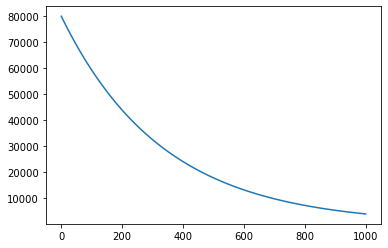

In [33]:
xx = numpy.linspace(0,1000,100)
yy = 80000*numpy.exp(-0.003*xx)
plt.plot(xx,yy)

In [1]:
import argparse
import os
import re
import numpy as np

import statistics
import msprime
from IPython.display import SVG, display
import tsinfer
import scipy
import math
import numpy
import tskit
import io
import builtins
import sys
from tqdm.notebook import tqdm
from tskit import MISSING_DATA
import pickle
import random
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import matrix, spmatrix, sparse
from cvxopt.solvers import qp, options
from cvxopt import blas
from cvxopt import spdiag
import statsmodels
from statsmodels.nonparametric.kernel_regression import KernelReg
from scipy.signal import savgol_filter
import time
import bisect


def find_s(elem, sorted_list):
    'Locate the leftmost value exactly equal to x'
    i = bisect.bisect_left(sorted_list, elem)
    if i != len(sorted_list) and sorted_list[i] == elem:
        return i


def find_s_se(elem, sorted_list):
    'Locate the leftmost value smaller or equal to x'
    i = bisect.bisect_right(sorted_list, elem)
    if i != 0:
        return i-1
    else:
        print("error")


def find_s_s(elem, sorted_list):
    'Locate the leftmost value smaller or equal to x'
    i = bisect.bisect_left(sorted_list, elem)
    if i != 0:
        return i
    else:
        return 0

 
    
file = open("recombination_map.dat","rb")
rmap = pickle.load(file)
file.close

sam=tsinfer.load("tgp_chr20.samples")

MSLlist = []
for i in range(len(sam.individuals_population)):
    if sam.individuals_population[i]==13:
        MSLlist.append(i)
newdata = sam.subset(individuals=MSLlist)
        
    
    
seq_len = 63025522
sam_size = 85
r = rmap
mu = 1.375*10**(-8)
# gene_conver = 10**(-8)
# track_len = 100
# epsilon = 0.0001
totaliter=1

simtime = 2
# priormu = [1.0*10**(-8), 2.0*10**(-8)]
# prioreps = [0, 0.0002]
# accept_threshold = [1000,400]
freqconsider = [1,300]
priorinipop = [120000, 5000]
priorinirate = [-0.001 , 0.004]





inipopsimlist = []
iniratesimlist = []
summary_sta1_simlist = []
summary_sta2_simlist = []
summary_sta3_simlist = []
summary_sta4_simlist = []

current_pop = []
for iter in range(totaliter):

    sitefreq = numpy.sum(newdata.sites_genotypes,1)
    siteuse =  numpy.where( (sitefreq>freqconsider[0] ) * ( sitefreq<freqconsider[1] ) )[0]  
    print("siteuse_rea",len(siteuse))
    datause = newdata.subset(sites = siteuse)
    inferred_ts = tsinfer.infer(datause,path_compression=False)

#     inferred_ts = tsinfer.infer(newdata,path_compression=False)



    mts = inferred_ts

    ###############################################################################
    msites = mts.tables.mutations.site
    sitepos = mts.tables.sites.position
    mpos = []
    for i in range(len(msites)):
        cursite = msites[i]
        mpos.append(sitepos[cursite])
    mpos = numpy.array(mpos)
    mnodes = mts.tables.mutations.node
    ec = mts.tables.edges.child
    ep = mts.tables.edges.parent
    el = mts.tables.edges.left
    er = mts.tables.edges.right


    leftmost = min(el)
    rightmost = max(er)
    for i in range(len(el)):
        if el[i] == leftmost:
            el[i] = 0
        if er[i] == rightmost:
            er[i] = seq_len


    if len(mpos) == 0:
        mpos_sn = []
        mnodes_sn = []
    else:
        mnp_sn = numpy.transpose(sorted(numpy.transpose(numpy.array([mnodes,mpos])).tolist()))
        mnodes_sn = mnp_sn[0]
        mpos_sn = mnp_sn[1]

    eclrp_sc = numpy.transpose(sorted(numpy.transpose(numpy.array([ec,el,er,ep])).tolist()))
    ec_sc = eclrp_sc[0]
    el_sc = eclrp_sc[1]
    er_sc = eclrp_sc[2]
    ep_sc = eclrp_sc[3]
    enm_sc = [[] for i in range(len(ec_sc))]

    curedge = 0
    for i in range(len(mnodes_sn)):
        curnodemu = mnodes_sn[i] 
        cursitemu = mpos_sn[i]
        for j in range(curedge,len(ec_sc)):
            if curnodemu == ec_sc[j]:

                if er_sc[j] > cursitemu and el_sc[j] <= cursitemu:

                    enm_sc[j].append(cursitemu)  

                    curedge = j
                    break
                if el_sc[j] > cursitemu:
                    curedge = j
                    break

            if ec_sc[j] > mnodes_sn[i] or j == len(ec_sc)-1:
                #print("missing mutations")
                curedge = j
                break




    ###########################################################################
    ###########################################################################
    ##########################################################################

    clocate = []
    curc = -1
    for i in range(len(ec_sc)):
        while ec_sc[i] != curc:
            curc=curc+1
            clocate.append(i)
    clocate.append(len(ec_sc))




    abdlist = []

    for i in range(0,2*sam_size-1):
        for j in range(i+1,i+2):
            canabd = []
            curleft = 0
            curright =seq_len
            #start = 0
            while curleft != seq_len:
                curp1 = i
                curp2 = j 
                curmed = []
                while curp1 != curp2:
                    if curp1 < curp2:
                        begin1 = clocate[curp1]
                        end = clocate[curp1+1]
                        s_range = el_sc[begin1:end]
                        begin2 = find_s_se(curleft,s_range)
                        for k in range(begin1+begin2,end):
                            if el_sc[k]<=curleft and er_sc[k] > curleft:
                                curp1 = int(ep_sc[k])
                                curoldr = curright
                                curright = min(er_sc[k],curright)

                                curmed.append(k)

                                break

                    else:
                        begin1 = clocate[curp2]
                        end = clocate[curp2+1]
                        s_range = el_sc[begin1:end]
                        begin2 = find_s_se(curleft,s_range)
                        for k in range(begin1+begin2,end):
                            if el_sc[k]<=curleft and er_sc[k] > curleft:
                                curp2 = int(ep_sc[k])
                                curoldr = curright
                                curright = min(er_sc[k],curright) 

                                curmed.append(k)

                                break

                canmution = []
                for k in range(len(curmed)):
                    edgemu = enm_sc[curmed[k]]
                    startt = find_s_s(curleft,edgemu)
                    endd = find_s_s(curright,edgemu)                    
                    canmution = canmution + edgemu[startt:endd] 

                canabd.append([i,j,curleft,curright,curp1,canmution])
                curleft = curright
                curright = seq_len





            if len(canabd)==1:
                abdlist = abdlist + canabd
            else:
                curabd = [canabd[0][0],canabd[0][1],canabd[0][2],canabd[0][3],canabd[0][4],canabd[0][5]]
                for k in range(1,len(canabd)):
                    if canabd[k][4] != canabd[k-1][4]:
                        abdlist.append(curabd)
                        curabd = [canabd[k][0],canabd[k][1],canabd[k][2],canabd[k][3],canabd[k][4],canabd[k][5]]
                    else:
                        curabd[3] = canabd[k][3]
                        curabd[5] = curabd[5] + canabd[k][5]
                    if k == len(canabd)-1:
                        abdlist.append(curabd)



#             print("abdlist sample:",i)
    print("numibd",len(abdlist))
    
    abduse = abdlist

#########################################################################

    tolnummu = 0
    for i in range(len(abduse)):
        tolnummu = tolnummu+len(abduse[i][5])


    muloclist = np.zeros(tolnummu)
    indd = 0
    for i in range(len(abduse)):
        abdc = abduse[i]
        lee = len(abdc[5])
        muloclist[indd:(indd+lee)] = abdc[5]
        indd = indd+lee

    smulist = numpy.sort(muloclist)
    count2 = 0
    curloc = -1
    curcount = 1
    for i in range(len(smulist)):
        if smulist[i] == curloc:
            curcount = curcount+1
        else:
            if curcount ==2:
                count2 = count2+1
            curcount = 1
            curloc = smulist[i]

#         summary_sta1_sim = (len(smulist) - 2*count2)/len(abduse)        
#         summary_sta2_sim = (2*count2) / len(abduse)

    summary_sta1_inf = (len(smulist) - 2*count2)        
    summary_sta2_inf = (2*count2)  




########################################################################            



    lenlist = numpy.zeros(len(abduse))
    for i in range(len(abduse)):
        lenlist[i] = abduse[i][3] - abduse[i][2]

    summary_sta3_inf = statistics.mean(lenlist) 
    summary_sta4_inf = statistics.stdev(lenlist) 

#################################################################################################
    stime = time.time()

    for run in range(simtime):
        
        popsim = numpy.random.uniform(priorinipop[0],priorinipop[1])
        ratesim = numpy.random.uniform(priorinirate[0],priorinirate[1])

        if run == 0:
            popsim = 13000
            ratesim = 0
        if run == 1:
            popsim = 20000
            ratesim = 0
#         if run == 2:
#             popsim = 8000
#             ratesim = 0.001
#         if run == 3:
#             popsim = 8000
#             ratesim = 0.004            
#         if run == 4:
#             popsim = 20000
#             ratesim = 0.000          
#         if run == 5:
#             popsim = 20000
#             ratesim = 0.000    
        
        
###      model  pop = const_a + inip * exp(inir * x)   when x<1000, when x =1000, pop = known pop, 2 parameters          
        inipopsimlist.append(popsim)
        iniratesimlist.append(ratesim)
        
        
#         demo_model = msprime.Demography.isolated_model([popsim], growth_rate=[ratesim])
#         demo_model.add_population_parameters_change(1000,  initial_size=None, growth_rate=0, population=None)
#         if ratesim < 0.0001:
#             demo_model.add_population_parameters_change(20000,  initial_size=None, growth_rate=0.0001, population=None)
        
        

        genpoint = [0*5/5.2,400*5/5.2,800*5/5.2,1200*5/5.2,1600*5/5.2,2000*5/5.2,2400*5/5.2,2800*5/5.2,\
                    3200*5/5.2,3600*5/5.2,4000*5/5.2,8000*5/5.2,12000*5/5.2,16000*5/5.2,20000*5/5.2]
        inipopsize =[12500,12500,11900,11500,10600,9600,9000,9600,10600,11900,13500,28500,26900,20800,17300]
        genuse = []
        inipuse = []
        gruse = []
        for i in range(len(genpoint)-1):
            addplist = []
            for j in range(10):
                addplist.append(genpoint[i] + (genpoint[i+1]-genpoint[i])/10*j)
            genuse = genuse + addplist               
        for i in range(len(inipopsize)-1):
            addplist = []
            for j in range(10):
                addplist.append(inipopsize[i] + (inipopsize[i+1]-inipopsize[i])/10*j)
            inipuse = inipuse + addplist
        genuse.append(genpoint[len(genpoint)-1])
        inipuse.append(inipopsize[len(inipopsize)-1])

        
        ind1000 = 0
        for i in range(len(genuse)):
            if genuse[i]<1000:
                ind1000 = i
        consta = inipuse[ind1000] - popsim*numpy.exp(-ratesim*1000)        
        for i in range(len(genuse)):
            if genuse[i]<1000:
                inipuse[i] = consta + popsim*numpy.exp(-ratesim*genuse[i]) 
        for i in range(len(genuse)-1):
            gruse.append( numpy.log( inipuse[i]/inipuse[i+1] )/(genuse[i+1] - genuse[i])  )
        gruse.append(0)
        
        current_pop.append( consta + popsim)
        if consta+popsim <1000:
            demo_model = msprime.Demography.isolated_model([1000], growth_rate=[0.001])
        else:
            demo_model = msprime.Demography.isolated_model([inipuse[0]], growth_rate=[gruse[0]])
            for i in range(1,len(genuse)):
                demo_model.add_population_parameters_change(genuse[i],  initial_size=inipuse[i], growth_rate=gruse[i], population=None)

                
                

#         for i in range(len(genuse)-1):
#             gruse.append( numpy.log( inipuse[i]/inipuse[i+1] )/(genuse[i+1] - genuse[i])  )
#         gruse.append(0)
        

#         demo_model = msprime.Demography.isolated_model([inipuse[0]], growth_rate=[gruse[0]])
#         for i in range(1,len(genuse)):
#             demo_model.add_population_parameters_change(genuse[i],  initial_size=inipuse[i], growth_rate=gruse[i], population=None)





#####################################################
        ts = msprime.sim_ancestry(
            samples=sam_size,
            recombination_rate= r, 
            sequence_length= seq_len,
            record_provenance=False,
#             population_size = pop_size,
#             gene_conversion_rate = gene_conver ,
#             gene_conversion_tract_length = track_len,
            #random_seed =seed,
            #discrete_genome=False
            demography = demo_model
            )
        # Visualise the simulated ancestral history.
        #SVG(ts.draw_svg())

        #ts.num_trees
        
        print("done gene")

        mts = msprime.sim_mutations(ts, rate = mu,
                                    #discrete_genome=False,
                                    #random_seed=seed
                                  )

        print("done mu")

        sample_data = tsinfer.SampleData.from_tree_sequence(mts, use_sites_time=None, use_individuals_time=None)

    
        sitefreq = numpy.sum(sample_data.sites_genotypes,1)
        siteuse =  numpy.where( (sitefreq>freqconsider[0] ) * ( sitefreq<freqconsider[1] ) )[0]  
        print("siteuse_sim",len(siteuse))
        datause = sample_data.subset(sites = siteuse)
        inferred_ts = tsinfer.infer(datause,path_compression=False)

#         inferred_ts = tsinfer.infer(sample_data,path_compression=False)

        mts = inferred_ts

        ###############################################################################
        msites = mts.tables.mutations.site
        sitepos = mts.tables.sites.position
        mpos = []
        for i in range(len(msites)):
            cursite = msites[i]
            mpos.append(sitepos[cursite])
        mpos = numpy.array(mpos)
        mnodes = mts.tables.mutations.node
        ec = mts.tables.edges.child
        ep = mts.tables.edges.parent
        el = mts.tables.edges.left
        er = mts.tables.edges.right


        leftmost = min(el)
        rightmost = max(er)
        for i in range(len(el)):
            if el[i] == leftmost:
                el[i] = 0
            if er[i] == rightmost:
                er[i] = seq_len


        if len(mpos) == 0:
            mpos_sn = []
            mnodes_sn = []
        else:
            mnp_sn = numpy.transpose(sorted(numpy.transpose(numpy.array([mnodes,mpos])).tolist()))
            mnodes_sn = mnp_sn[0]
            mpos_sn = mnp_sn[1]

        eclrp_sc = numpy.transpose(sorted(numpy.transpose(numpy.array([ec,el,er,ep])).tolist()))
        ec_sc = eclrp_sc[0]
        el_sc = eclrp_sc[1]
        er_sc = eclrp_sc[2]
        ep_sc = eclrp_sc[3]
        enm_sc = [[] for i in range(len(ec_sc))]

        curedge = 0
        for i in range(len(mnodes_sn)):
            curnodemu = mnodes_sn[i] 
            cursitemu = mpos_sn[i]
            for j in range(curedge,len(ec_sc)):
                if curnodemu == ec_sc[j]:

                    if er_sc[j] > cursitemu and el_sc[j] <= cursitemu:

                        enm_sc[j].append(cursitemu)  

                        curedge = j
                        break
                    if el_sc[j] > cursitemu:
                        curedge = j
                        break

                if ec_sc[j] > mnodes_sn[i] or j == len(ec_sc)-1:
                    #print("missing mutations")
                    curedge = j
                    break




        ###########################################################################
        ###########################################################################
        ##########################################################################

        clocate = []
        curc = -1
        for i in range(len(ec_sc)):
            while ec_sc[i] != curc:
                curc=curc+1
                clocate.append(i)
        clocate.append(len(ec_sc))




        abdlist = []

        for i in range(0,2*sam_size-1):
            for j in range(i+1,i+2):
                canabd = []
                curleft = 0
                curright =seq_len
                #start = 0
                while curleft != seq_len:
                    curp1 = i
                    curp2 = j 
                    curmed = []
                    while curp1 != curp2:
                        if curp1 < curp2:
                            begin1 = clocate[curp1]
                            end = clocate[curp1+1]
                            s_range = el_sc[begin1:end]
                            begin2 = find_s_se(curleft,s_range)
                            for k in range(begin1+begin2,end):
                                if el_sc[k]<=curleft and er_sc[k] > curleft:
                                    curp1 = int(ep_sc[k])
                                    curoldr = curright
                                    curright = min(er_sc[k],curright)

                                    curmed.append(k)

                                    break

                        else:
                            begin1 = clocate[curp2]
                            end = clocate[curp2+1]
                            s_range = el_sc[begin1:end]
                            begin2 = find_s_se(curleft,s_range)
                            for k in range(begin1+begin2,end):
                                if el_sc[k]<=curleft and er_sc[k] > curleft:
                                    curp2 = int(ep_sc[k])
                                    curoldr = curright
                                    curright = min(er_sc[k],curright) 

                                    curmed.append(k)

                                    break

                    canmution = []
                    for k in range(len(curmed)):
                        edgemu = enm_sc[curmed[k]]
                        startt = find_s_s(curleft,edgemu)
                        endd = find_s_s(curright,edgemu)                    
                        canmution = canmution + edgemu[startt:endd] 

                    canabd.append([i,j,curleft,curright,curp1,canmution])
                    curleft = curright
                    curright = seq_len





                if len(canabd)==1:
                    abdlist = abdlist + canabd
                else:
                    curabd = [canabd[0][0],canabd[0][1],canabd[0][2],canabd[0][3],canabd[0][4],canabd[0][5]]
                    for k in range(1,len(canabd)):
                        if canabd[k][4] != canabd[k-1][4]:
                            abdlist.append(curabd)
                            curabd = [canabd[k][0],canabd[k][1],canabd[k][2],canabd[k][3],canabd[k][4],canabd[k][5]]
                        else:
                            curabd[3] = canabd[k][3]
                            curabd[5] = curabd[5] + canabd[k][5]
                        if k == len(canabd)-1:
                            abdlist.append(curabd)


    #             print("abdlist sample:",i)
        print("numibd",len(abdlist))

        abduse = abdlist

#########################################################################

        tolnummu = 0
        for i in range(len(abduse)):
            tolnummu = tolnummu+len(abduse[i][5])


        muloclist = np.zeros(tolnummu)
        indd = 0
        for i in range(len(abduse)):
            abdc = abduse[i]
            lee = len(abdc[5])
            muloclist[indd:(indd+lee)] = abdc[5]
            indd = indd+lee
            
        smulist = numpy.sort(muloclist)
        count2 = 0
        curloc = -1
        curcount = 1
        for i in range(len(smulist)):
            if smulist[i] == curloc:
                curcount = curcount+1
            else:
                if curcount ==2:
                    count2 = count2+1
                curcount = 1
                curloc = smulist[i]
        
#         summary_sta1_sim = (len(smulist) - 2*count2)/len(abduse)        
#         summary_sta2_sim = (2*count2) / len(abduse)

        summary_sta1_sim = (len(smulist) - 2*count2)        
        summary_sta2_sim = (2*count2)  

        summary_sta1_simlist.append(summary_sta1_sim)
        summary_sta2_simlist.append(summary_sta2_sim)
        
        
########################################################################            
        
        

        lenlist = numpy.zeros(len(abduse))
        for i in range(len(abduse)):
            lenlist[i] = abduse[i][3] - abduse[i][2]

        summary_sta3_simlist.append( statistics.mean(lenlist) )
        summary_sta4_simlist.append( statistics.stdev(lenlist) )
        
        print("-----------------------------------")
        print("current_pop",current_pop )
        print(inipopsimlist )
        print(iniratesimlist )
        print(summary_sta1_simlist,summary_sta1_inf)
        print(summary_sta2_simlist,summary_sta2_inf)
        print(summary_sta3_simlist,summary_sta3_inf)
        print(summary_sta4_simlist,summary_sta4_inf)
        print(time.time()-stime, run)
        print("-----------------------------------")



# byrun = 1
# name1 = "b_ne_realpopsimall_"+"run="+str(byrun) +"MSL_efibd.dat"
# name2 = "b_ne_realratesimall_"+"run="+str(byrun) +"MSL_efibd.dat"
# name3 = "b_ne_realsta1simall_"+"run="+str(byrun) +"MSL_efibd.dat"
# name4 = "b_ne_realsta2simall_"+"run="+str(byrun) +"MSL_efibd.dat"
# name5 = "b_ne_realsta1inf_"+"run="+str(byrun) +"MSL_efibd.dat"
# name6 = "b_ne_realsta2inf_"+"run="+str(byrun) +"MSL_efibd.dat"

# file = open(name1,"wb") 
# pickle.dump(inipopsimlist,file)
# file.close()

# file = open(name2,"wb") 
# pickle.dump(iniratesimlist,file)
# file.close()

# file = open(name3,"wb") 
# pickle.dump(summary_sta1_simlist,file)
# file.close()

# file = open(name4,"wb") 
# pickle.dump(summary_sta2_simlist,file)
# file.close()

# file = open(name5,"wb") 
# pickle.dump(summary_sta1_inf,file)
# file.close()

# file = open(name6,"wb") 
# pickle.dump(summary_sta2_inf,file)
# file.close()


siteuse_rea 317938
numibd 2527015
done gene
done mu
siteuse_sim 261130
numibd 1698624


NameError: name 'summary_sta3_simlist' is not defined

In [3]:
statistics.mean(lenlist)

6270.553823565427

In [10]:
summary_sta4_inf

31405.01856975117

(0.0, 20000.0)

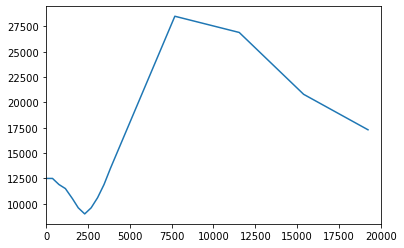

In [34]:
plt.plot(genuse,inipuse)
plt.xlim(0,20000)


In [9]:
min(inipuse)

9000.0